In [1]:
video_path = "C://Users//dorag//Downloads//pippi_on_the_run.AVI"

## Just Limb Position Timeseries

## Video and Data

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Initialize mediapipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Number of landmarks in the pose model
NUM_LANDMARKS = 33  # Change this based on the model you are using

# Function to process a frame and extract pose landmarks
def process_frame(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    landmarks = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y]) # Add z for 3D positions
    else:
        # If no landmarks, append zeros
        landmarks = [[0, 0]] * NUM_LANDMARKS
    return landmarks


# Start video capture
#cap = cv2.VideoCapture(video_path)
cap = cv2.VideoCapture(0)

# Store landmarks for each frame
landmarks_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Extract landmarks
    landmarks = process_frame(frame)
    landmarks_over_time.append(landmarks)

    # Plotting for every frame (or every few frames for efficiency)
    if len(landmarks_over_time) % 5 == 0:  # Update every 5 frames
        landmarks_array = np.array(landmarks_over_time)
        if landmarks_array.size > 0:
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

            # Plot video frame
            axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Video Frame')
            axs[0].axis('off')

            # Plot landmark data
            axs[1].imshow(landmarks_array[:, :, 0].T, aspect='auto')
            axs[1].set_xlabel('Frame')
            axs[1].set_ylabel('Landmark')
            axs[1].set_title('Landmark X Positions Over Time')

            # Calculate and plot correlation matrix
            reshaped_data = landmarks_array.reshape(landmarks_array.shape[0], -1)  # Reshape for correlation
            correlation_matrix = np.corrcoef(reshaped_data.T, rowvar=False)
            im = axs[2].imshow(correlation_matrix, aspect='auto', cmap='viridis')
            axs[2].set_title('Correlation Matrix')
            fig.colorbar(im, ax=axs[2])  # Add colorbar to correlation plot

            clear_output(wait=True)
            display(plt.gcf())
            plt.close()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [17]:
! pip install mediapipe

(5, 66)

(5, 33, 2)

## Pose Overlaid

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Initialize mediapipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Start video capture
cap = cv2.VideoCapture(0)

# Store landmarks for each frame
landmarks_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    # Extract landmarks and draw them on the frame
    landmarks = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y]) # Add z for 3D positions
        mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    else:
        landmarks = [[0, 0]] * 33  # Assuming 33 landmarks

    landmarks_over_time.append(landmarks)

    # Update plots every few frames for efficiency
    if len(landmarks_over_time) % 2 == 0: 
        landmarks_array = np.array(landmarks_over_time)
        if landmarks_array.size > 0:
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

            # Plot video frame with poses
            axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Video Frame with Pose')
            axs[0].axis('off')

            # Plot landmark data
            axs[1].imshow(landmarks_array[:, :, 0].T, aspect='auto')
            axs[1].set_xlabel('Frame')
            axs[1].set_ylabel('Landmark')
            axs[1].set_title('Landmark X Positions Over Time')

            # Calculate and plot frame-by-frame correlation matrix
            reshaped_data = landmarks_array.reshape(landmarks_array.shape[0], -1)
            correlation_matrix = np.corrcoef(reshaped_data)
            im = axs[2].imshow(correlation_matrix, aspect='auto', cmap='viridis')
            axs[2].set_title('Frame-by-Frame Correlation Matrix')
            fig.colorbar(im, ax=axs[2])

            clear_output(wait=True)
            display(plt.gcf())
            plt.close()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Initialize mediapipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Function to process a frame and adjust landmarks relative to body's center
def process_frame(image, pose):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    landmarks = []
    if results.pose_landmarks:
        # Find the center (midpoint between hips)
        hip_left = np.array([results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x, 
                             results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y])
        hip_right = np.array([results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x, 
                              results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y])
        center = (hip_left + hip_right) / 2

        # Adjust all landmarks relative to the center
        for landmark in results.pose_landmarks.landmark:
            adjusted_x = landmark.x - center[0]
            adjusted_y = landmark.y - center[1]
            landmarks.append([adjusted_x, adjusted_y])

    return landmarks, results

# Start video capture
cap = cv2.VideoCapture(0)

# Store landmarks for each frame
landmarks_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame
    adjusted_landmarks, pose_results = process_frame(frame, pose)
    landmarks_over_time.append(adjusted_landmarks)

    # Update plots for every frame (or every few frames for efficiency)
    if len(landmarks_over_time) % 5 == 0:
        landmarks_array = np.array(landmarks_over_time)
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Draw pose on the video frame
        if pose_results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                pose_results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Video Frame with Pose')
        axs[0].axis('off')

        # Plot adjusted landmark data
        if landmarks_array.size > 0:
            axs[1].imshow(landmarks_array[:, :, 0], aspect='auto')
            axs[1].set_xlabel('Frame')
            axs[1].set_ylabel('Landmark')
            axs[1].set_title('Adjusted Landmark X Positions Over Time')

            # Calculate and plot frame-by-frame correlation matrix
            reshaped_data = landmarks_array.reshape(landmarks_array.shape[0], -1)  # Reshape for correlation
            correlation_matrix = np.corrcoef(reshaped_data)
            im = axs[2].imshow(correlation_matrix, aspect='auto', cmap='viridis')
            axs[2].set_title('Frame-by-Frame Correlation Matrix')
            fig.colorbar(im, ax=axs[2])

        clear_output(wait=True)
        display(plt.gcf())
        plt.close()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


## Body Centric

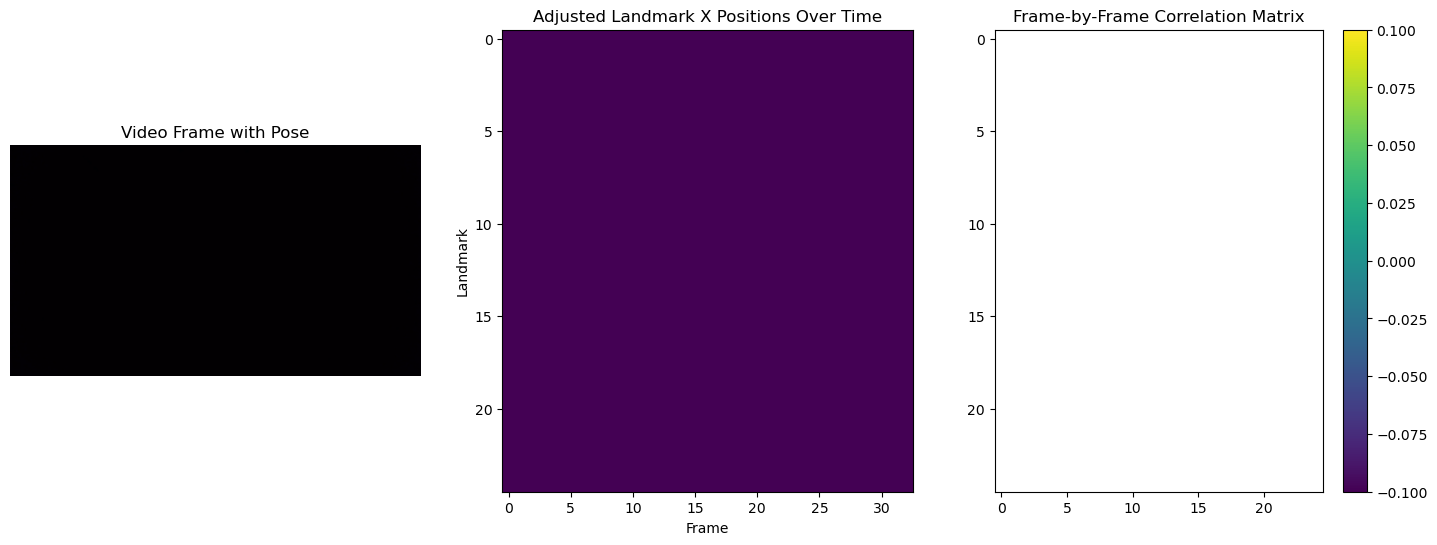

KeyboardInterrupt: 

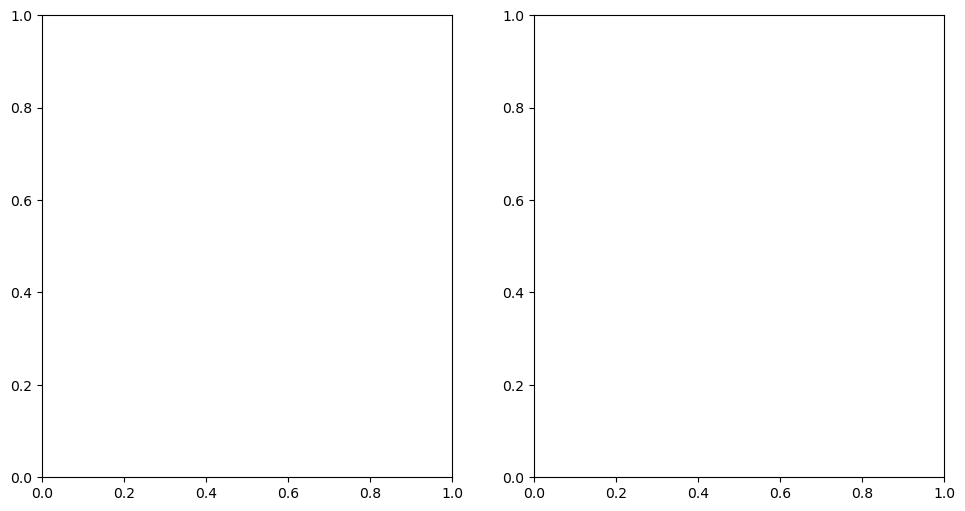

In [3]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Initialize mediapipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Function to process a frame and adjust landmarks relative to body's center
def process_frame(image, pose):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    landmarks = np.zeros((NUM_LANDMARKS, 2))  # Initialize with zeros
    if results.pose_landmarks:
        # Find the center (midpoint between hips)
        hip_left = np.array([results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x, 
                             results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y])
        hip_right = np.array([results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x, 
                              results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y])
        center = (hip_left + hip_right) / 2

        # Adjust all landmarks relative to the center
        for i, landmark in enumerate(results.pose_landmarks.landmark):
            adjusted_x = landmark.x - center[0]
            adjusted_y = landmark.y - center[1]
            landmarks[i] = [adjusted_x, adjusted_y]

    return landmarks, results

# Start video capture
cap = cv2.VideoCapture(0)

# Store landmarks for each frame
landmarks_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame
    adjusted_landmarks, pose_results = process_frame(frame, pose)
    landmarks_over_time.append(adjusted_landmarks)

    # Update plots for every frame (or every few frames for efficiency)
    if len(landmarks_over_time) % 5 == 0:
        landmarks_array = np.array(landmarks_over_time)
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Draw pose on the video frame
        if pose_results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                pose_results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Video Frame with Pose')
        axs[0].axis('off')

        # Plot adjusted landmark data
        if landmarks_array.size > 0:
            axs[1].imshow(landmarks_array[:, :, 0], aspect='auto')
            axs[1].set_xlabel('Frame')
            axs[1].set_ylabel('Landmark')
            axs[1].set_title('Adjusted Landmark X Positions Over Time')

            # Calculate and plot frame-by-frame correlation matrix
            reshaped_data = landmarks_array.reshape(landmarks_array.shape[0], -1)  # Reshape for correlation
            correlation_matrix = np.corrcoef(reshaped_data)
            im = axs[2].imshow(correlation_matrix, aspect='auto', cmap='viridis')
            axs[2].set_title('Frame-by-Frame Correlation Matrix')
            fig.colorbar(im, ax=axs[2])

        clear_output(wait=True)
        display(plt.gcf())
        plt.close()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## With states?

KeyboardInterrupt: 

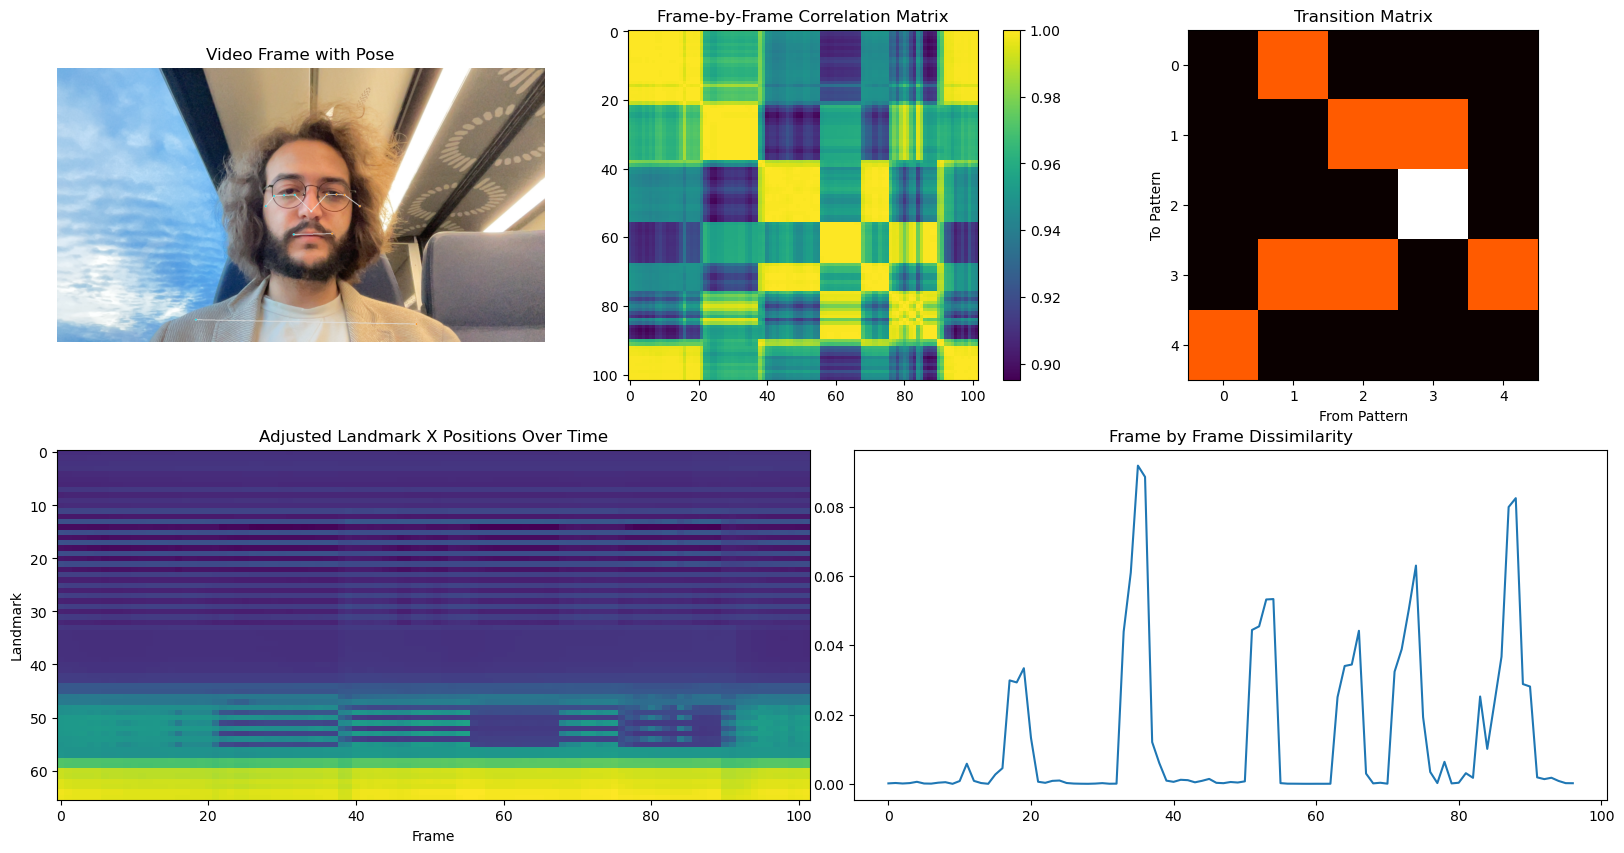

In [34]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# Function to process a frame and adjust landmarks relative to body's center
def process_frame(image, pose):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    landmarks = np.zeros((NUM_LANDMARKS, 2))  # Initialize with zeros
    if results.pose_landmarks:
        # Find the center (midpoint between hips)
        hip_left = np.array([results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x, 
                             results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y])
        hip_right = np.array([results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x, 
                              results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y])
        center = (hip_left + hip_right) / 2

        # Adjust all landmarks relative to the center
        for i, landmark in enumerate(results.pose_landmarks.landmark):
            adjusted_x = landmark.x - center[0]
            adjusted_y = landmark.y - center[1]
            landmarks[i] = [adjusted_x, adjusted_y]

    return landmarks, results


# Initialize mediapipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def calculate_vector(results):
    # Calculate the feature vector from the pose landmarks
    if not results.pose_landmarks:
        return np.zeros((33, 2))
    
    return np.array([[lm.x, lm.y] for lm in results.pose_landmarks.landmark])

def dissimilarity(vec1, vec2):
    # Calculate dissimilarity between two vectors (Euclidean distance)
    return 1 - np.corrcoef(vec1.flatten() , vec2.flatten())[0][1]

def update_patterns(patterns, new_pattern, threshold=0.990):
    # Update the existing patterns with the new pattern based on correlation
    if len(patterns)==0:
        # Add a new pattern entry if no similar pattern is found
        patterns.append({'average': new_pattern, 'count': 1})
        
    for current_pattern_index,pattern in enumerate(patterns):
        if np.corrcoef(pattern['average'].flatten(), new_pattern.flatten())[0, 1] > threshold:
            pattern['average'] = (pattern['average'] + new_pattern) / 2
            update_transition_matrix(current_pattern_index)
            return patterns

    
    patterns.append({'average': new_pattern})
    current_pattern_index = len(patterns)-1 
    
    ####### update transition matrix
    
    
    #current_pattern_index = len(patterns)
    
    global transition_matrix
    # Resize the transition matrix
    new_size = len(patterns)
    new_matrix = np.zeros((new_size, new_size))
    old_size = transition_matrix.shape[0]

    # Copy the old data into the new matrix
    new_matrix[:old_size, :old_size] = transition_matrix
    transition_matrix = new_matrix
    
    update_transition_matrix(current_pattern_index)
    #######
    return patterns


def update_transition_matrix(current_pattern_index):
    global last_pattern_index
    if last_pattern_index is not None and current_pattern_index is not None:
        if last_pattern_index != current_pattern_index:
            transition_matrix[last_pattern_index, current_pattern_index] += 1
    last_pattern_index = current_pattern_index

# Function to plot the transition matrix
def plot_transition_matrix(axs):
    axs.imshow(transition_matrix, cmap='hot', interpolation='nearest')
    #axs.colorbar()
    axs.set_title("Transition Matrix")
    axs.set_xlabel("From Pattern")
    axs.set_ylabel("To Pattern")
    

NUM_LANDMARKS = 33
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
# Start webcam input
cap = cv2.VideoCapture(0)

dissimilarity_over_time = []
landmarks_over_time = []
patterns = []
last_threshold_frame = 0
#THRESHOLD = 0.1 # Set your dissimilarity threshold

# Assuming 'patterns' is your list of patterns
num_patterns = len(patterns)
transition_matrix = np.zeros((1, 1))

last_pattern_index = None  # To keep track of the last pattern


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (176, 144)) 
    adjusted_landmarks, pose_results = process_frame(resized_frame, pose)
    # Process the frame and get pose landmarks
    #pose_results = process_frame(frame)
    current_vector = calculate_vector(pose_results)
    landmarks_over_time.append(current_vector)
    
    if len(landmarks_over_time)>5:
        # Check dissimilarity with the previous frame
        dissimilarity_over_time.append(dissimilarity(current_vector, landmarks_over_time[-5]))
        
        percent_changes = np.diff(dissimilarity_over_time[-5:]) / dissimilarity_over_time[-5:][1:] * 100
        THRESHOLD = np.mean(percent_changes)*2
        
        if dissimilarity(current_vector, landmarks_over_time[-2]) > THRESHOLD: # very sensitive parameter, not threshold but the index of comparison of n-back
            # Average landmarks from last threshold to current frame
            new_pattern = np.mean(landmarks_over_time[last_threshold_frame:], axis=0)
            patterns = update_patterns(patterns, new_pattern)
            last_threshold_frame = len(landmarks_over_time)

    

        # Update plots for every frame (or every few frames for efficiency)
        if len(landmarks_over_time) % 2 == 0:
            landmarks_array = np.array(landmarks_over_time)

            # Figure
            #fig, axs = plt.subplots(1, 5, figsize=(20, 6))
            
            # Create figure
            fig = plt.figure(figsize=(20, 10))

            # Set up the grid
            gs = gridspec.GridSpec(2, 6)

            # Create 3 subplots in the top row
            ax1 = fig.add_subplot(gs[0, 0:2])  # Top row, first column
            ax2 = fig.add_subplot(gs[0, 2:4])  # Top row, second column
            ax3 = fig.add_subplot(gs[0, 4:6])  # Top row, third column

            # Create 2 subplots in the bottom row, each spanning 1.5 columns
            ax4 = fig.add_subplot(gs[1, 0:3]) # Bottom row, span first and second columns
            ax5 = fig.add_subplot(gs[1, 3:]) # Bottom row, span second and third columns

            
            # Draw pose on the video frame
            if pose_results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    pose_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            ax1.set_title('Video Frame with Pose')
            ax1.axis('off')

            # Plot adjusted landmark data
            if landmarks_array.size > 0:
                ax4.imshow(np.vstack([landmarks_array[:, :, 0].T,landmarks_array[:, :, 1].T]), aspect='auto')
                ax4.set_xlabel('Frame')
                ax4.set_ylabel('Landmark')
                ax4.set_title('Adjusted Landmark X Positions Over Time')

                # Calculate and plot frame-by-frame correlation matrix
                reshaped_data = landmarks_array.reshape(landmarks_array.shape[0], -1)  # Reshape for correlation
                correlation_matrix = np.corrcoef(reshaped_data)
                im = ax2.imshow(correlation_matrix, aspect='equal', cmap='viridis')
                ax2.set_title('Frame-by-Frame Correlation Matrix')
                fig.colorbar(im, ax=ax2)

                ax5.plot(dissimilarity_over_time)
                # ax5.axhline(THRESHOLD,color='red')
                ax5.set_title('Frame by Frame Dissimilarity')
                plot_transition_matrix(ax3)
                
            clear_output(wait=True)
            display(plt.gcf())
            plt.close()


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Displaying the patterns
print("Detected Patterns:", len(patterns))


In [35]:
print("Detected Patterns:", len(patterns))

Detected Patterns: 5


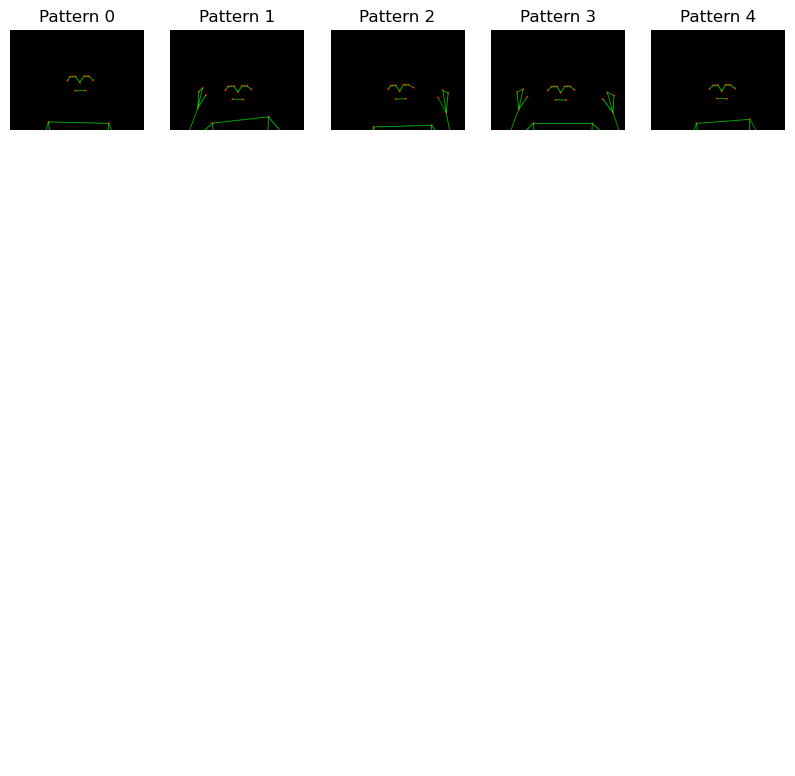

In [36]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

def draw_pose(landmarks, image):
    # Create a blank image to draw on
    if image is None:
        image = np.zeros((480, 640, 3), dtype=np.uint8)

    # Check and draw each landmark
    for landmark in landmarks:
        if landmark is not None and len(landmark) == 2:
            # Convert normalized coordinates to image coordinates
            x = int(landmark[0] * image.shape[1])
            y = int(landmark[1] * image.shape[0])
            cv2.circle(image, (x, y), 5, (255, 0, 0), -1)

    # Draw connections
    for connection in mp_pose.POSE_CONNECTIONS:
        start_idx, end_idx = connection
        if landmarks[start_idx] is not None and landmarks[end_idx] is not None:
            start_x = int(landmarks[start_idx][0] * image.shape[1])
            start_y = int(landmarks[start_idx][1] * image.shape[0])
            end_x = int(landmarks[end_idx][0] * image.shape[1])
            end_y = int(landmarks[end_idx][1] * image.shape[0])
            cv2.line(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

    return image


# fig ,axs = plt.subplots()
# # Example of plotting a pose
# for pattern_id, pattern in enumerate(patterns):
#     avg_landmarks = pattern['average']
#     avg_landmarks = [None if np.array_equal(landmark, [0, 0]) else landmark for landmark in avg_landmarks]
#     pose_image = draw_pose(avg_landmarks, None)
    
#     plt.figure(figsize=(8, 6))
#     plt.suptitle('Pattern '+ str(pattern_id))
#     plt.imshow(cv2.cvtColor(pose_image, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()

fig ,axs = plt.subplots(int(np.floor(np.sqrt(19))),int(np.ceil(np.sqrt(19))),figsize=(10,10))
count = 0
for i in range(int(np.floor(np.sqrt(19)))):
    for j in range(int(np.ceil(np.sqrt(19)))):
        
        if count<len(patterns):
            pattern = patterns[count]
            avg_landmarks = pattern['average']
            avg_landmarks = [None if np.array_equal(landmark, [0, 0]) else landmark for landmark in avg_landmarks]
            pose_image = draw_pose(avg_landmarks, None)


            axs[i,j].set_title('Pattern ' + str(count) )
            axs[i,j].imshow(pose_image)
            axs[i,j].axis('off')
            count += 1
        axs[i,j].axis('off')
plt.show()

ToDo:
- now the poses are statically averaged in time windows. find a way to capture dynamic poses -> repeating sequences in a hierarchy
- faster fps
- better feature change metric
- 

In [33]:
np.sqrt(len(patterns))

4.0

In [38]:
np.floor(np.sqrt(19))

4.0

In [40]:
np.ceil(np.sqrt(19))

5.0

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Initialize mediapipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Number of landmarks in the pose model
NUM_LANDMARKS = 33  # Change this based on the model you are using

# Function to process a frame and extract pose landmarks
def process_frame(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    landmarks = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y]) # Add z for 3D positions
    else:
        # If no landmarks, append zeros
        landmarks = [[0, 0]] * NUM_LANDMARKS
    return landmarks


# Start video capture
#cap = cv2.VideoCapture(video_path)
cap = cv2.VideoCapture(0)

# Store landmarks for each frame
landmarks_over_time = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Extract landmarks
    landmarks = process_frame(frame)
    landmarks_over_time.append(landmarks)

    # Plotting for every frame (or every few frames for efficiency)
    if len(landmarks_over_time) % 5 == 0:  # Update every 5 frames
        landmarks_array = np.array(landmarks_over_time)
        if landmarks_array.size > 0:
            plt.figure(figsize=(10, 6))
            plt.imshow(landmarks_array[:, :, 0].T, aspect='auto')  # Update as needed
            plt.xlabel('Frame')
            plt.ylabel('Landmark')
            plt.title('Landmark X Positions Over Time')
            plt.colorbar()

            clear_output(wait=True)
            display(plt.gcf())
            plt.close()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
